In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import xgboost as xgb
import sqlite3
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
#Read the final_features data frame
df_nlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
df_ppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

df1 = df_nlp.drop(['qid1','qid2'],axis=1)
df2 = df_ppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df  = df1.merge(df2, on='id',how='left')

In [3]:
print ("Minimum length of the questions in Question 1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in Question 2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [Question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [Question2] :", df[df['q2_n_words']== 1].shape[0])

print ("\nMaximum length of the questions in Question 1 : " , max(df['q1_n_words']))
print ("Maximum length of the questions in Question 2 : " , max(df['q2_n_words']))

print ("\nAverage length of the questions in Question 1 : " , np.mean(df['q1_n_words']))
print ("Average length of the questions in Question 2 : " , np.mean(df['q2_n_words']))

Minimum length of the questions in Question 1 :  1
Minimum length of the questions in Question 2 :  1
Number of Questions with minimum length [Question1] : 67
Number of Questions with minimum length [Question2] : 24

Maximum length of the questions in Question 1 :  125
Maximum length of the questions in Question 2 :  237

Average length of the questions in Question 1 :  10.94459175344431
Average length of the questions in Question 2 :  11.185119592371812


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 30 columns):
id                      404290 non-null int64
question1               404276 non-null object
question2               404284 non-null object
is_duplicate            404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc_min                 404290 non-null float64
csc_max                 404290 non-null float64
ctc_min                 404290 non-null float64
ctc_max                 404290 non-null float64
last_word_eq            404290 non-null float64
first_word_eq           404290 non-null float64
abs_len_diff            404290 non-null float64
mean_len                404290 non-null float64
token_set_ratio         404290 non-null int64
token_sort_ratio        404290 non-null int64
fuzz_ratio              404290 non-null int64
fuzz_partial_ratio      404290 non-null int64
longest_substr_ratio    404290 non-null

## Basic Feature Extraction (before cleaning)



* freq_qid1 = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of Question 1
* q2len = Length of Question 2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total = (Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2





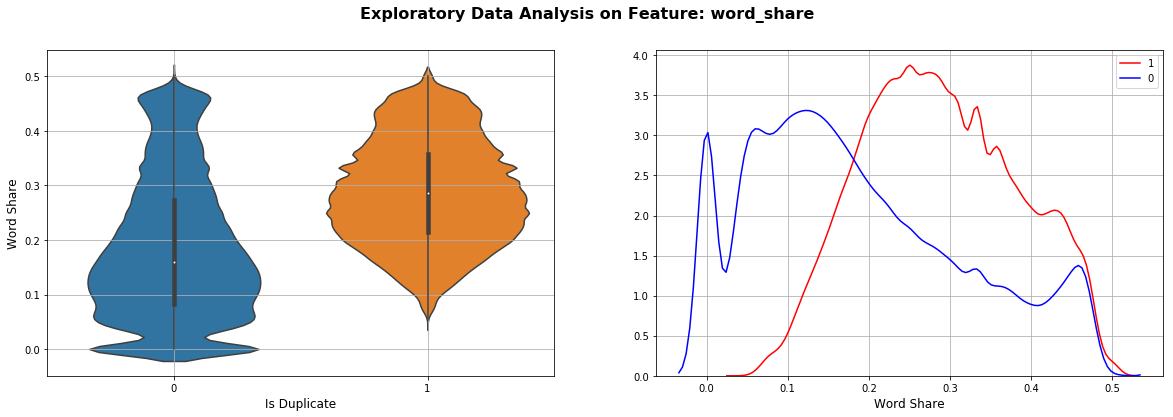

In [5]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_share", data = df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Word Share",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], label = "1", color = "red", hist=False)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], label = "0", color = "blue", hist=False)
plt.xlabel("Word Share",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: word_share",fontsize=16,fontweight="bold")
plt.show()

### Observation:
* The violin plots gives a fair idea of how many values are present in each quantile range
* The distributions of duplicate vs non duplicate questions based on word-share feature seems to be partially overlapping. 
* This feature may be useful for classification

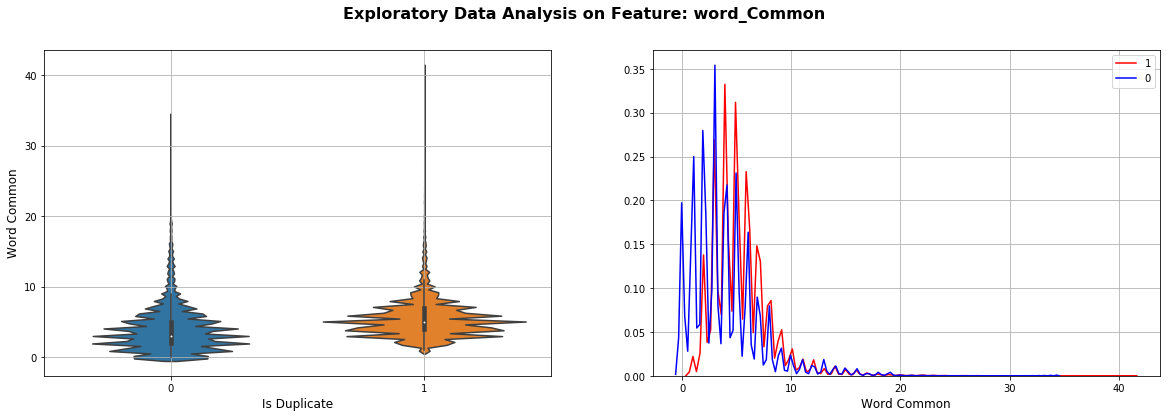

In [6]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_Common", data = df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Word Common",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'], label = "1", color = "red", hist=False)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'], label = "0", color = "blue", hist=False)
plt.xlabel("Word Common",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: word_Common",fontsize=16,fontweight="bold")
plt.show()

### Observation:
* The distributions of duplicate vs non duplicate questions based on word_common feature seems to be overlapping a lot 
* This feature may not be useful for classification

### Advanced Feature Extraction (NLP and Fuzzy Features)

#### Definition:

* Token: We get a token by splitting sentence with a space
* Stop_Word : stop words as per NLTK.
* Word : A token that is not a stop_word

#### Token Features:

* cwc_min : Ratio of common_word_count to min length of word count of Q1 and Q2 
* cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 
* cwc_max : Ratio of common_word_count to max length of word count of Q1 and Q2 
* cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 
* csc_min : Ratio of common_stop_count to min length of stop count of Q1 and Q2 
* csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 
* csc_max : Ratio of common_stop_count to max length of stop count of Q1 and Q2
* csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 
* ctc_min : Ratio of common_token_count to min length of token count of Q1 and Q2
* ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 
* ctc_max : Ratio of common_token_count to max length of token count of Q1 and Q2
* ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 
* last_word_eq : Check if First word of both questions is equal or not
* last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 
* first_word_eq : Check if First word of both questions is equal or not
* first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 
* abs_len_diff : Abs. length difference
* abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 
* mean_len : Average Token Length of both Questions
* mean_len = (len(q1_tokens) + len(q2_tokens))/2 


#### Fuzzy and NLP Features: 

* fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* longest_substr_ratio : Ratio of length longest common substring to min length of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


###  Pair plot of 'ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'  features.


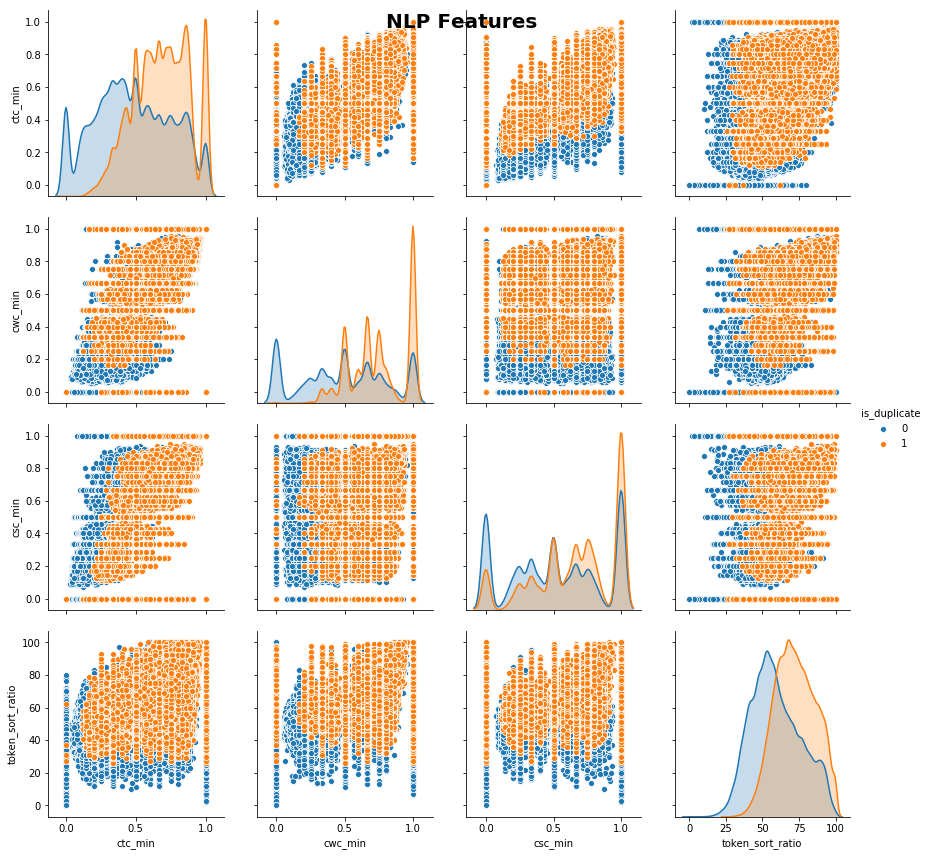

In [7]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'],size = 3)
plt.suptitle("NLP Features",weight = 'bold').set_fontsize('20')
plt.show()

### Observation:
* From the pair-plot ,it is evident that there is partial overlapping between the datapoints
* So the features ctc_min,csc_min and token_sort_ratio maybe useful for classfication


### EDA on "token_sort_ratio" feature

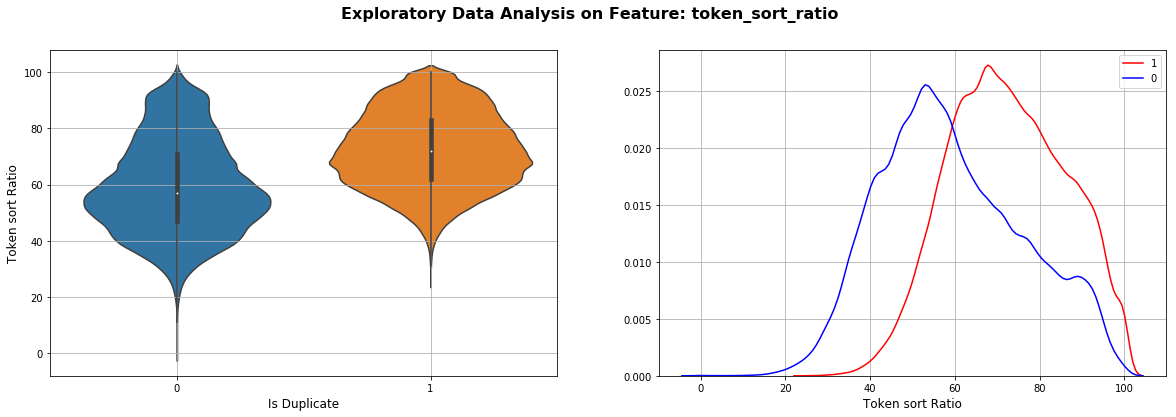

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "token_sort_ratio", data = df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Token sort Ratio",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'], label = "1", color = "red", hist=False)
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'], label = "0", color = "blue", hist=False)
plt.xlabel("Token sort Ratio",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: token_sort_ratio",fontsize=16,fontweight="bold")
plt.show()

### Observation:
* The violin plots gives a fair idea of how many values are present in each quantile range
* The distributions of duplicate vs non duplicate questions based on token_sort_ratio feature seems to be partially overlapping. 

* This feature may be useful for classification

### TSNE Visualization in 2D space.

In [9]:
from sklearn.preprocessing import MinMaxScaler


df_sample = df[0:20000]
X = MinMaxScaler().fit_transform(df_sample[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
Y = df_sample['is_duplicate'].values

In [10]:
tsne2d = TSNE(
    n_components=2,
    perplexity = 40,
    init='random',
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.110s...
[t-SNE] Computed neighbors for 20000 samples in 2.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

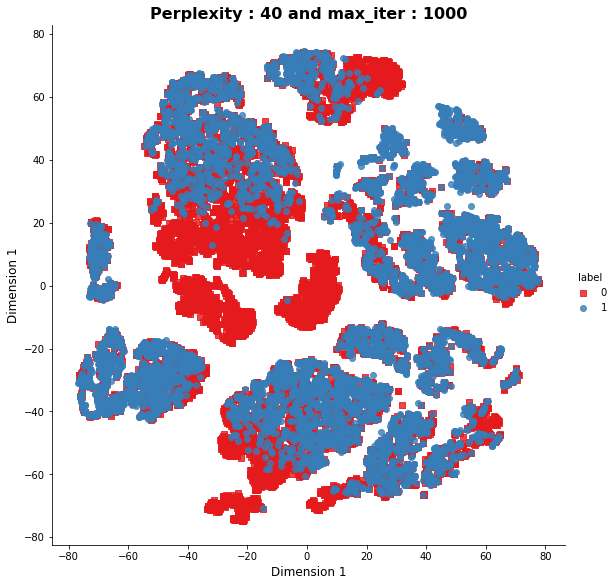

In [11]:
tsne2d_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':Y})


sns.lmplot(data=tsne2d_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("Perplexity : {} and max_iter : {}".format(40, 1000),fontsize = 16,fontweight = 'bold')
plt.xlabel("Dimension 1",fontsize = 12)
plt.ylabel("Dimension 1",fontsize = 12)
plt.show()

### TSNE Visualization in 3D Space

In [12]:
tsne3d = TSNE(
    n_components=3,
    perplexity = 40,
    init='random',
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)


x,y,z = tsne3d[:,0].tolist(),tsne3d[:,1].tolist(),tsne3d[:,2].tolist()
tsne_3d = pd.DataFrame(
    {'X Label': x,
     'Y Label': y,
     'Z Label': z,
     'Label': Y.tolist()
    })

tsne3d_0 = tsne_3d.loc[tsne_3d['Label'] == 0]
tsne3d_1 = tsne_3d.loc[tsne_3d['Label'] == 1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.107s...
[t-SNE] Computed neighbors for 20000 samples in 2.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

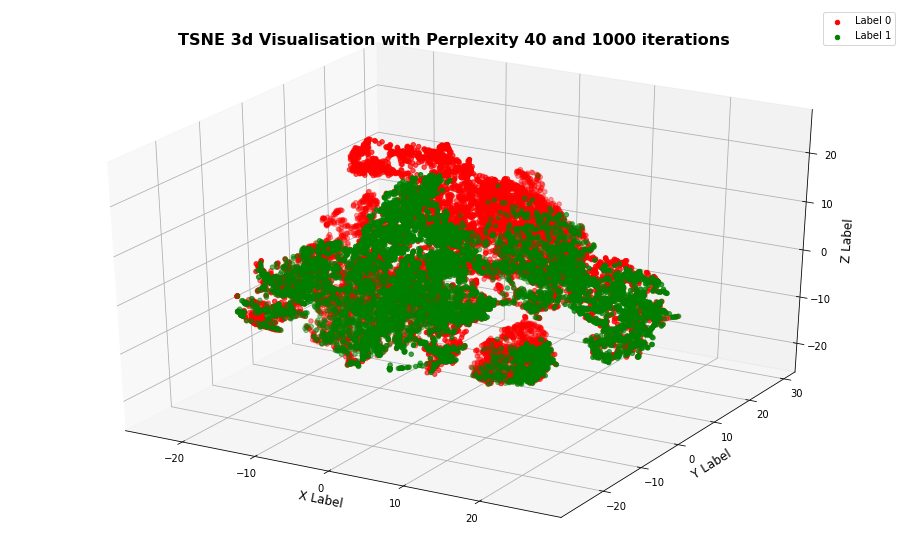

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3d_0['X Label'], tsne3d_0['Y Label'], tsne3d_0['Z Label'],c ='r',label='Label 0', marker='o')
ax.scatter(tsne3d_1['X Label'], tsne3d_1['Y Label'], tsne3d_1['Z Label'],c = 'g',label='Label 1', marker='o')
ax.set_xlabel('X Label',fontsize = 12)
ax.set_ylabel('Y Label',fontsize = 12)
ax.set_zlabel('Z Label',fontsize = 12)
ax.set_title("TSNE 3d Visualisation with Perplexity 40 and 1000 iterations",fontsize = 16,fontweight ='bold')
ax.legend()

plt.show()

In [14]:
df = df[0:100000] #we are considering 100k datapoints for this assignment

In [15]:
#Remove the first row 
#data.drop(data.index[0], inplace=True)
y_true = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)

## Removing nan values in question 1 and question 2

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
stopwords= stopwords.words("english")

In [18]:
df['question1'] = df['question1'].str.lower()

In [19]:
df['question2'] = df['question2'].str.lower()

In [20]:
df['question1'] = df['question1'].fillna('')

In [21]:
df['question2'] = df['question2'].fillna('')

In [22]:
q1 =  df['question1'].values.tolist()
     

In [23]:
q2 = df['question2'].values.tolist()

In [24]:
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [25]:
from tqdm import tqdm
preprocessed_q1 = []
for i in tqdm(q1):
    preprocessed_q1.append(preprocess(i))

100%|██████████| 100000/100000 [00:19<00:00, 5126.86it/s]


In [26]:
from tqdm import tqdm
preprocessed_q2 = []
for i in tqdm(q2):
    preprocessed_q2.append(preprocess(i))

100%|██████████| 100000/100000 [00:19<00:00, 5127.54it/s]


In [27]:
df['preprocessed_q1'] = preprocessed_q1
df['preprocessed_q2'] = preprocessed_q2


In [28]:
df['preprocessed_q1'].head()

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor  koh i noor  dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely  how can i solve...
4    which one dissolve in water quikly sugar  salt...
Name: preprocessed_q1, dtype: object

In [29]:
df['preprocessed_q2'].head()

0    what is the step by step guide to invest in sh...
1    what would happen if the indian government sto...
2    how can internet speed be increased by hacking...
3    find the remainder when  math 23  24   math  i...
4              which fish would survive in salt water 
Name: preprocessed_q2, dtype: object

# Train-Test Split

In [30]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [31]:
print("Split ratio")
print('-'*50)
print('Train dataset:',len(X_train)/len(df)*100,'%\n','size:',len(X_train))
print('-'*50)
print('Test dataset:',len(X_test)/len(df)*100,'%\n','size:',len(X_test))

Split ratio
--------------------------------------------------
Train dataset: 70.0 %
 size: 70000
--------------------------------------------------
Test dataset: 30.0 %
 size: 30000


In [32]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 30)
Number of data points in test data : (30000, 30)


In [33]:
X_train.head()

,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2
27621,how can reaction times be measured,are there any muslims in aiims rishikesh if y...,0.000000,0.000000,0.333322,0.111110,0.166664,0.062500,0.0,0.0,...,84,6,16,1.0,22.0,0.045455,2,0,how can reaction times be measured,are there any muslims in aiims rishikesh if y...
29738,what should i do if someone steal my idea,what can you do if someone steals your idea,0.666644,0.666644,0.499992,0.499992,0.555549,0.555549,1.0,1.0,...,44,9,9,5.0,18.0,0.277778,2,0,what should i do if someone steal my idea,what can you do if someone steals your idea
76836,what is 7up,why is 7up called 7up,0.999900,0.499975,0.499975,0.499975,0.666644,0.399992,1.0,0.0,...,22,3,5,2.0,8.0,0.250000,2,0,what is 7up,why is 7up called 7up
47895,when did the mahabharata war happen,what are the strongest evidences that suggest ...,0.333322,0.142855,0.333322,0.199996,0.333328,0.153845,0.0,0.0,...,90,6,13,2.0,18.0,0.111111,2,0,when did the mahabharata war happen,what are the strongest evidences that suggest ...
73838,how hard is it for a good java developer with ...,how hard is it for a good java developer with ...,0.999990,0.999990,0.999989,0.899991,0.949995,0.904758,1.0,1.0,...,111,20,21,19.0,39.0,0.487179,2,0,how hard is it for a good java developer with ...,how hard is it for a good java developer with ...


### Converting text into tf-idf w2v vectors

In [34]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
from tqdm import tqdm
def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model

In [35]:
model = loadGloveModel('glove.42B.300d.txt')

1403it [00:00, 14029.28it/s]

Loading Glove Model


1917494it [02:10, 14669.43it/s]

Done. 1917494  words loaded!


In [36]:
q1_q2_train = X_train['preprocessed_q2'] + X_train['preprocessed_q2']

In [37]:
q1_q2 = []

for i in q1_q2_train :
    q1_q2.extend(i.split(' '))

In [38]:
## Find the total number of words in question1 and question2.

print("all the words ", len(q1_q2))


all the words  1726542


In [39]:
## Find the unique words 

q1_q2_train_words = set(q1_q2)
print("the unique words ", len(q1_q2_train_words))

the unique words  29015


In [40]:
## Find the words present in both Glove Vectors as well as our corpus.

inter_words = set(model.keys()).intersection(q1_q2_train_words)

print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(q1_q2_train_words))*100)))

The number of words that are present in both glove vectors and our corpus are 27615 which is nearly 95.0% 


In [41]:
words_corpus_train = {}

words_glove = set(model.keys())

for i in q1_q2_train_words:
    if i in words_glove:
        words_corpus_train[i] = model[i]

print("word 2 vec length", len(words_corpus_train))

word 2 vec length 27615


In [42]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus_train, f)


In [43]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [44]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_q1'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [45]:
# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_q1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_q1']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_q1.append(vector)

print(len(train_tfidf_w2v_q1))
print(len(train_tfidf_w2v_q1[0]))

100%|██████████| 70000/70000 [00:03<00:00, 19782.95it/s]

70000
300


In [46]:
# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_q2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_q2']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_q2.append(vector)

print(len(train_tfidf_w2v_q2))
print(len(train_tfidf_w2v_q2[0]))

100%|██████████| 70000/70000 [00:03<00:00, 19381.09it/s]

70000
300


In [47]:
# average Word2Vec
# compute average word2vec for each review.
test_tfidf_w2v_q1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_q1']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_q1.append(vector)

print(len(test_tfidf_w2v_q1))
print(len(test_tfidf_w2v_q1[0]))

100%|██████████| 30000/30000 [00:01<00:00, 20008.65it/s]

30000
300


In [48]:
# average Word2Vec
# compute average word2vec for each review.
test_tfidf_w2v_q2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_q2']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_q2.append(vector)

print(len(test_tfidf_w2v_q2))
print(len(test_tfidf_w2v_q2[0]))

100%|██████████| 30000/30000 [00:01<00:00, 19734.56it/s]

30000
300


In [49]:
from scipy.sparse import coo_matrix
train_tfidf_w2v_q1 = coo_matrix(train_tfidf_w2v_q1)
train_tfidf_w2v_q2 = coo_matrix(train_tfidf_w2v_q2)


In [50]:
test_tfidf_w2v_q1 = coo_matrix(test_tfidf_w2v_q1)
test_tfidf_w2v_q2 = coo_matrix(test_tfidf_w2v_q2)

In [51]:
train_tfidf = hstack((train_tfidf_w2v_q1,train_tfidf_w2v_q2))
test_tfidf = hstack((test_tfidf_w2v_q1,test_tfidf_w2v_q2))

In [52]:
#removing 
X_train.drop(['question1','question2','preprocessed_q1','preprocessed_q2'], axis=1, inplace=True)
X_test.drop(['question1','question2','preprocessed_q1','preprocessed_q2'], axis=1, inplace=True)

In [53]:
from scipy.sparse import hstack

X_train = hstack((X_train,train_tfidf)).tocsr()
X_test = hstack((X_test, test_tfidf)).tocsr()

In [65]:
print(X_test.shape)
print(X_train.shape)

(30000, 626)
(70000, 626)


In [67]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [63]:
import pickle
import numpy as np
import scipy.sparse


with open('X_train.dat', 'wb') as outfile:
    pickle.dump(X_train, outfile, pickle.HIGHEST_PROTOCOL)


In [64]:
with open('X_test.dat', 'wb') as outfile:
    pickle.dump(X_test, outfile, pickle.HIGHEST_PROTOCOL)

In [77]:
type(y_train)

pandas.core.series.Series

In [71]:
#https://datatofish.com/export-dataframe-to-csv/
y_train_csv = y_train.to_csv (r'y_train.csv', index = None, header=True)
#Don't forget to add '.csv' at the end of the path

In [72]:
#https://datatofish.com/export-dataframe-to-csv/
y_test_csv = y_test.to_csv (r'y_test.csv', index = None, header=True)
#Don't forget to add '.csv' at the end of the path

## the kernel kept getting restarted while training the models. So I have saved the train and test files

## please run vikram.iisccamp@gmail.com_20(2).ipynb to see how the models are performing.
